In [103]:
import kagglehub
import os
import pandas as pd
import numpy as np
import warnings
from scipy.stats import skew
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import joblib

# 1. `Load & Read Data Preprosses Data`

In [104]:
df = pd.read_csv("../notebook/data/preprosses_data.csv")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,0


### 1.1 `Train–Validation–Test Split` & `Balancing Data`

In [105]:
data = df.dropna().copy()
X = data.drop(['income'], axis=1)
y = data['income']

ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X, y)

### 1.2 Split the Data

In [106]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_over, y_over, test_size=0.1, random_state=42, stratify=y_over
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1111, random_state=42, stratify=y_train_full
)

### 1.3 Mormalize y_train `income` value

In [107]:
print(pd.Series(y_train).value_counts(normalize=True))

income
1    0.500009
0    0.499991
Name: proportion, dtype: float64


### 2. Feature Type Identification

#### `Categorical` & `Numerical` Features

In [108]:
categorical_cols = X_train.select_dtypes(include='object').columns
numeric_cols = X_train.select_dtypes(include=np.number).columns

print("Categorical features: ", categorical_cols)
print("Numerical features: ", numeric_cols)

Categorical features:  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object')
Numerical features:  Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


### 2.1 Skewness Detection

In [109]:
numeric_cols = X_train.select_dtypes(include=np.number).columns
skewed_feats = X_train[numeric_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_features = skewed_feats[skewed_feats > 0.8].index.tolist()
skewed_features = [col for col in skewed_features if col in X_train.columns]

print("High skew features:", skewed_features)

High skew features: ['capital-gain', 'capital-loss', 'fnlwgt']


### 3. Preprocessing Pipeline

In [110]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

### 3.1 Log Transformation in data

> Formula: `N!` = `N * 1 + N * 2 + N * 3 + ... + N * n`

In [111]:
log_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    StandardScaler()
)

### 3.2 Numeric Transformation

In [112]:
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

### 3.3 Categorical Transformation

In [113]:
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

### 3.4 Column Transformation

In [114]:
preprocessor = ColumnTransformer([
    ("log", log_transformer, skewed_features),

    ("num", numeric_transformer, list(set(numeric_cols) - set(skewed_features))),

    ("cat", categorical_transformer, categorical_cols),
])

### 4. Select Model as Baseline

> Logistic Regression 

In [115]:
from sklearn.linear_model import TheilSenRegressor, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, roc_curve
)

logistic_regression = Pipeline([
    ("preprocessor_logistic_regression", preprocessor),
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')),
])

random_forest = Pipeline([
    ("preprocessor_random_forest", preprocessor),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')),
])



### 4.1 Visualize model evaluation metrics in a 3x2 subplot grid.

1. Confusion Matrix
2. ROC Curve
3. Precision, Recall, F1 (Bar plot)
4. Validation Score (model.score)
5. Actual Accuracy
6. Placeholder for future metric or leave blank

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score, accuracy_score
)

def plot_model_evaluation(model, X_val, y_val, model_name="Model"):
    
    y_pred = model.predict(X_val)
    
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, y_proba)
        fpr, tpr, _ = roc_curve(y_val, y_proba)
    else:
        y_proba = y_pred
        auc_score = None
        fpr, tpr = None, None
    
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    actual_accuracy = accuracy_score(y_val, y_pred)
    validation_score = model.score(X_val, y_val)
    
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0, 0])
    axes[0, 0].set_title("Confusion Matrix")
    axes[0, 0].set_xlabel("Predicted")
    axes[0, 0].set_ylabel("Actual")
    
    if fpr is not None:
        axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {auc_score:.4f}")
        axes[0, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
        axes[0, 1].set_title("ROC Curve")
        axes[0, 1].set_xlabel("False Positive Rate")
        axes[0, 1].set_ylabel("True Positive Rate")
        axes[0, 1].legend(loc="lower right")
    else:
        axes[0, 1].text(0.5, 0.5, "ROC Not Available", ha='center', va='center')
        axes[0, 1].set_axis_off()
    
    metrics_dict = {"Precision": precision, "Recall": recall, "F1": f1}
    sns.barplot(x=list(metrics_dict.keys()), y=list(metrics_dict.values()), palette="viridis", ax=axes[1, 0])
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].set_title("Precision or Recall score or F1 score")
    
    axes[1, 1].bar([0], [validation_score], color='skyblue')
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].set_xticks([0])
    axes[1, 1].set_xticklabels([f"{model_name}"])
    axes[1, 1].set_title(f"Validation Score : {validation_score:.4f}")
    
    axes[2, 0].bar([0], [actual_accuracy], color='salmon')
    axes[2, 0].set_ylim(0, 1)
    axes[2, 0].set_xticks([0])
    axes[2, 0].set_xticklabels([f"{model_name}"])
    axes[2, 0].set_title(f"Actual Accuracy: {actual_accuracy:.4f}")
    
    axes[2, 1].text(0.5, 0.5, "Optional Metric", ha='center', va='center', fontsize=12)
    axes[2, 1].set_axis_off()
    
    plt.tight_layout()
    plt.show()
    
    print(f"{model_name} Algorithm Summary")
    print(f"Validation Score (model.score): {validation_score:.4f}")
    print(f"Actual Accuracy: {actual_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if auc_score is not None:
        print(f"ROC AUC: {auc_score:.4f}")


### 4.1 Model Arcitucture

In [117]:
logistic_regression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor_logistic_regression',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['capital-gain',
                                                   'capital-loss', 'fnlwgt']),
                                                 ('num',
                                                  Pipeline(...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))])),
                ('Logistic Regression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

### 4.2 Visualize Model Score

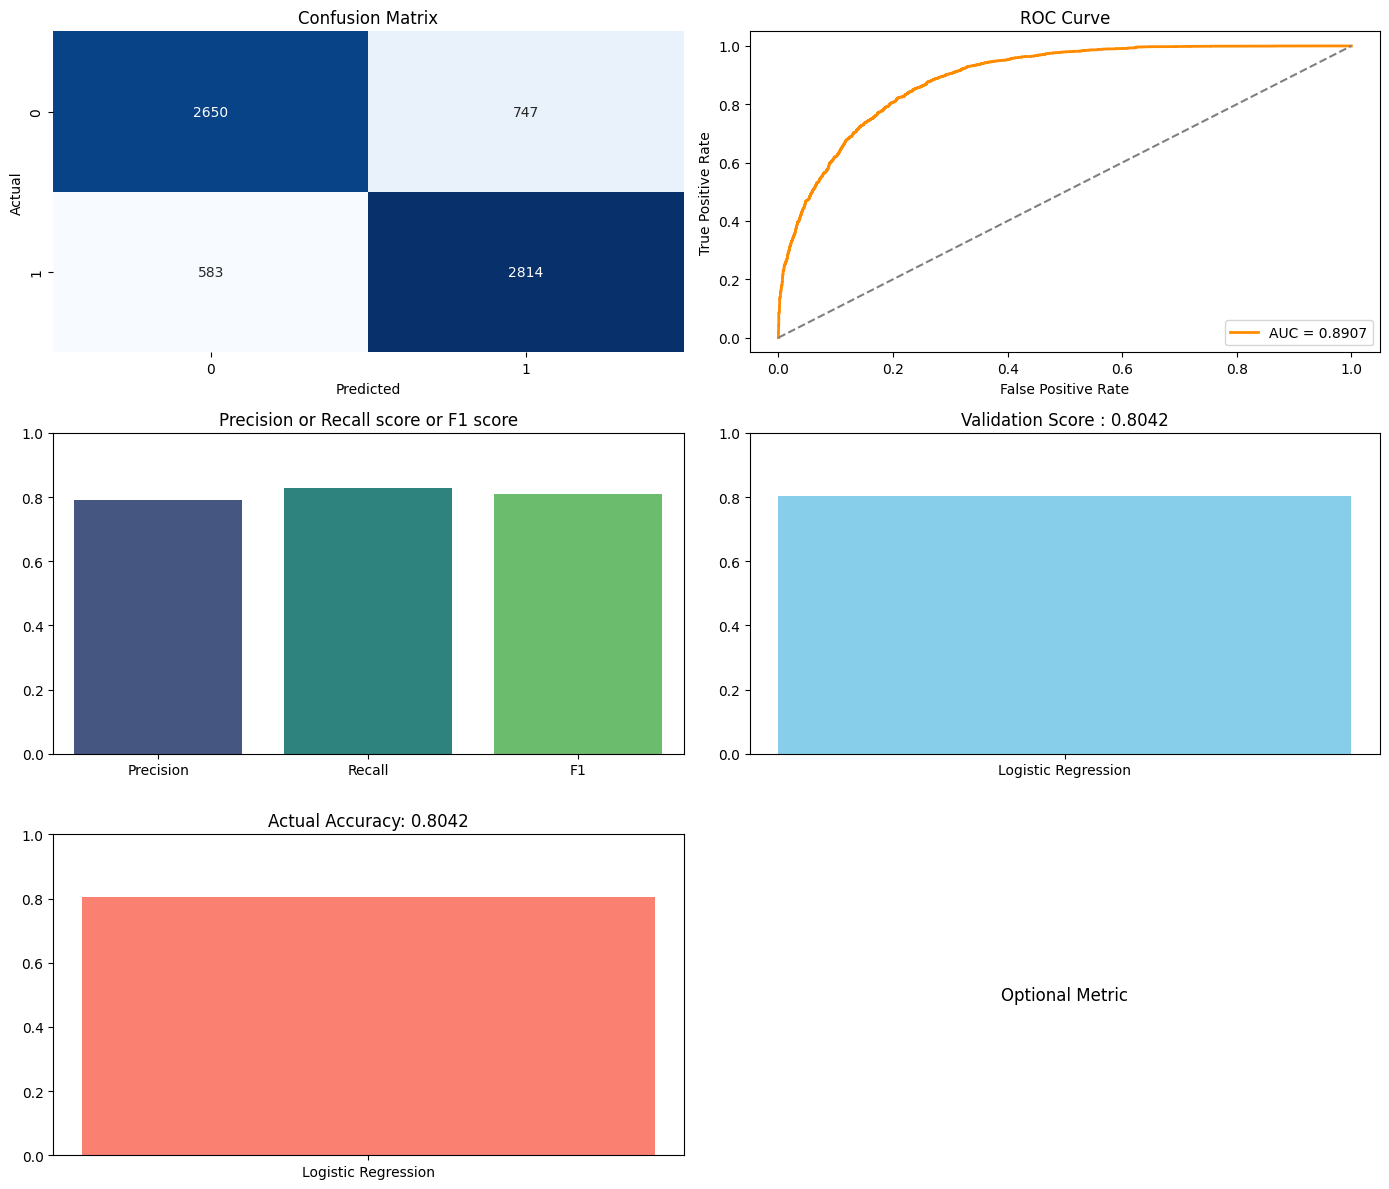

Logistic Regression Algorithm Summary
Validation Score (model.score): 0.8042
Actual Accuracy: 0.8042
Precision: 0.7902
Recall: 0.8284
F1 Score: 0.8089
ROC AUC: 0.8907


In [118]:
plot_model_evaluation(logistic_regression, X_val, y_val, model_name="Logistic Regression")

### 5. Embedded_layer_1:  `Logistic Regression` + `Gradient Boosting` 

In [119]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = Pipeline([
    ("preprocessor1", preprocessor),
    ("gb", GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42))
])

gb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor1',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['capital-gain',
                                                   'capital-loss', 'fnlwgt']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimpu...
                                                   'educational-num']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))])),
                ('gb',
                 GradientBoostingClassifier(n_estimators=200,
                                            random_state=42))])

### 5.1 Embedded_layer_2:  `Embedded_layer_1` + `XGBoost` 

In [120]:
from xgboost import XGBClassifier

xgb_model = Pipeline([
    ("preprocessor1", preprocessor),
    ("xgb", XGBClassifier(n_estimators=200, learning_rate=0.1, use_label_encoder=False, eval_metric="logloss", random_state=42))
])
xgb_model.fit(X_train, y_train)

y_val_pred_3 = xgb_model.predict(X_val)

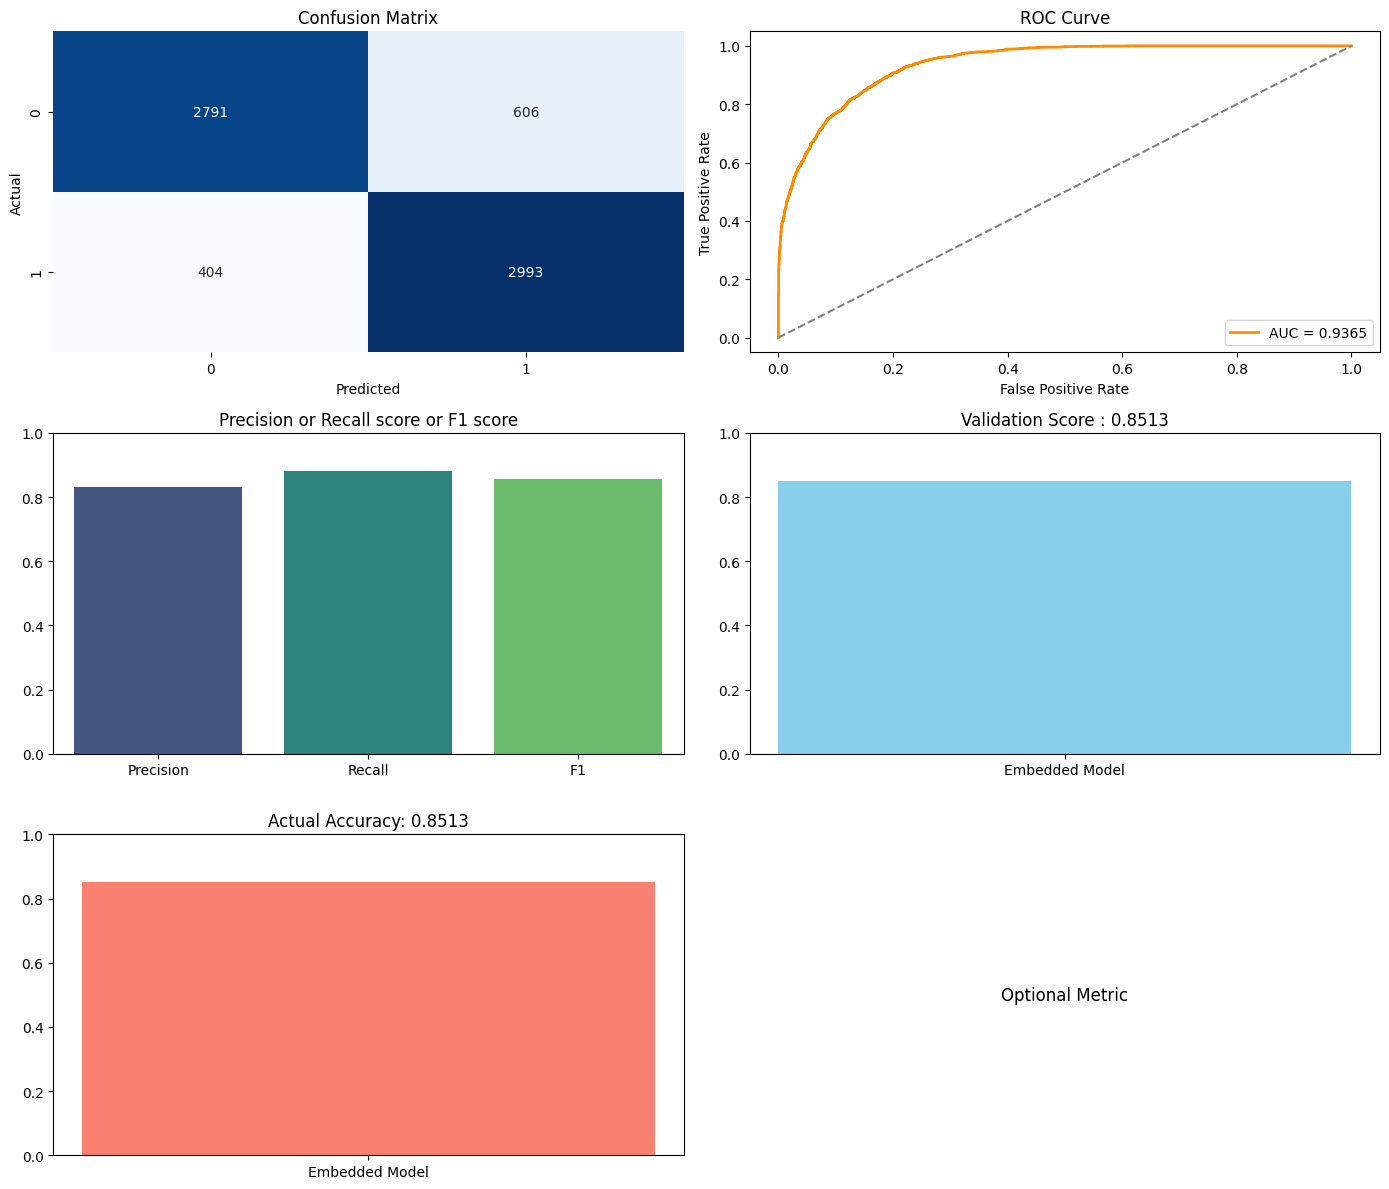

Embedded Model Algorithm Summary
Validation Score (model.score): 0.8513
Actual Accuracy: 0.8513
Precision: 0.8316
Recall: 0.8811
F1 Score: 0.8556
ROC AUC: 0.9365


In [121]:
plot_model_evaluation (xgb_model, X_val, y_val, model_name="Embedded Model")

### 5.2 Embedded_layer_3:  `Embedded_layer_2` + `Random Forest` 

In [122]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline([
    ("preprocessor1", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
])

rf_model.fit(X_train, y_train)

y_val_pred_2 = rf_model.predict(X_val)

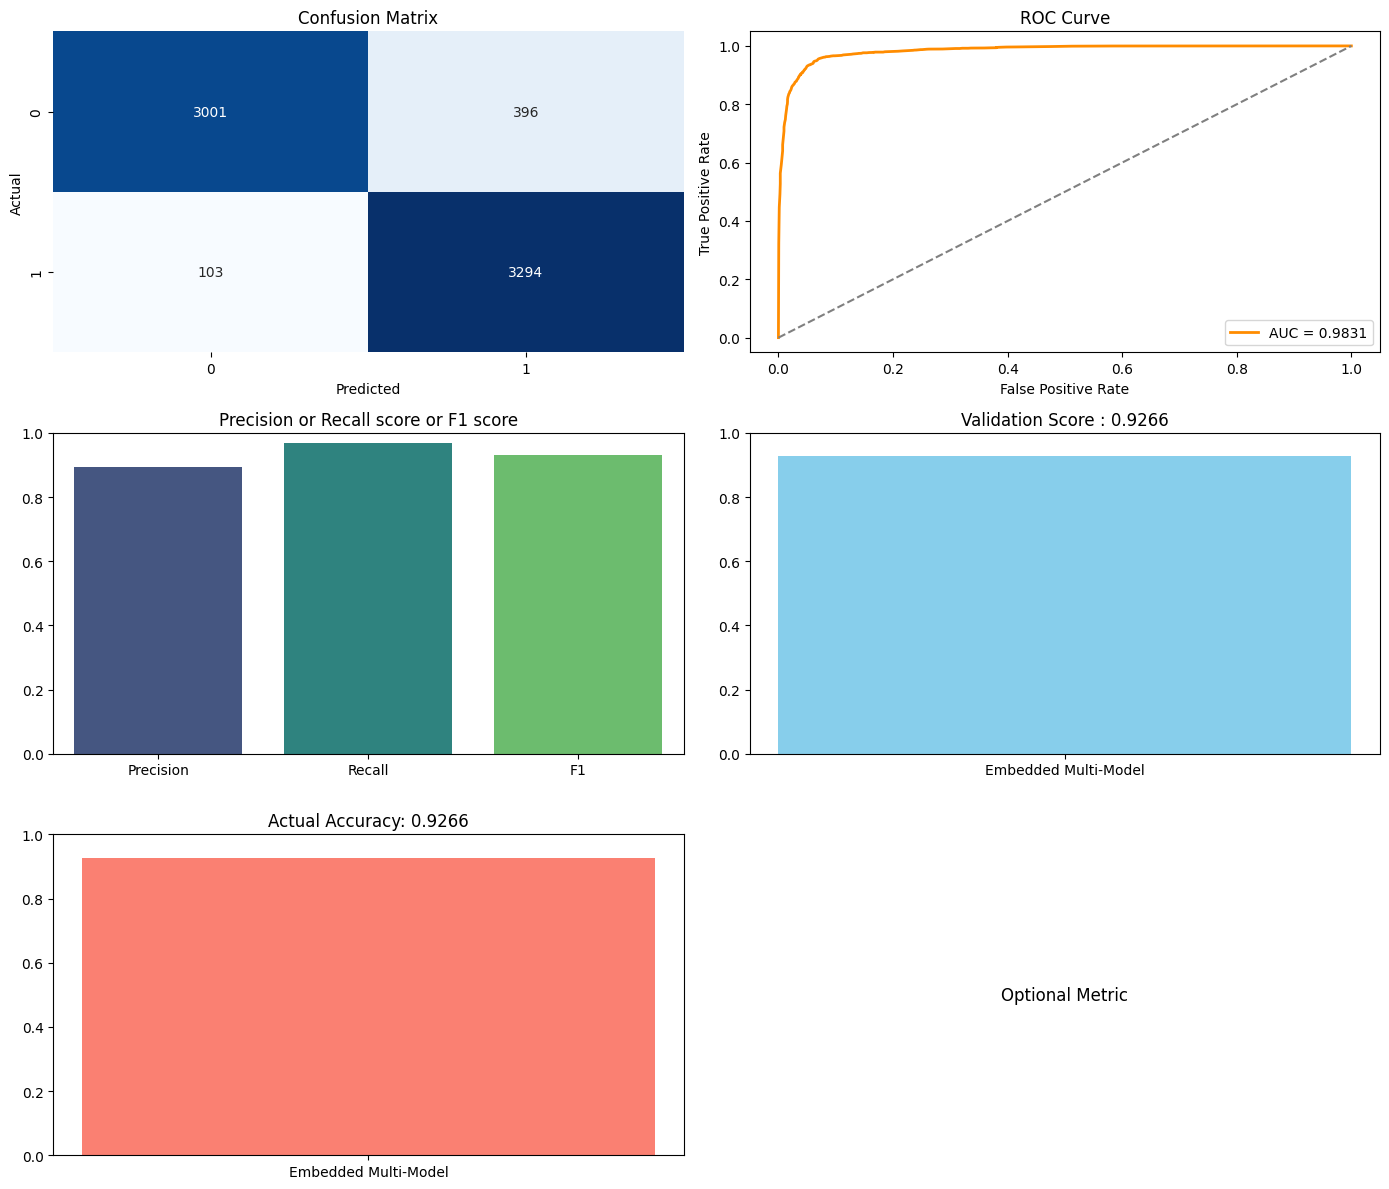

Embedded Multi-Model Algorithm Summary
Validation Score (model.score): 0.9266
Actual Accuracy: 0.9266
Precision: 0.8927
Recall: 0.9697
F1 Score: 0.9296
ROC AUC: 0.9831


In [123]:
plot_model_evaluation(rf_model,X_val, y_val, model_name="Embedded Multi-Model")

### 6. Model Ensembling `Stacking`

In [124]:
from sklearn.ensemble import StackingClassifier,  AdaBoostClassifier

rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
])

xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("xgb", XGBClassifier(n_estimators=200, learning_rate=0.1,
                          use_label_encoder=False, eval_metric="logloss", random_state=42))
])

gb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("gb", GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42))
])

### 6.1 Final Embedded Multi-Model Architecture

In [ ]:
stack_model = StackingClassifier(
    estimators=[
        ('rf', rf_pipeline),
        ('xgb', xgb_pipeline),
        ('gb', gb_pipeline),
    ],
    final_estimator=AdaBoostClassifier(n_estimators=100, learning_rate=0.5, random_state=42),
    cv=5,
    n_jobs=-1
)

stack_model.fit(X_train, y_train)

### 6.2 Embedded Multi-Model Performence

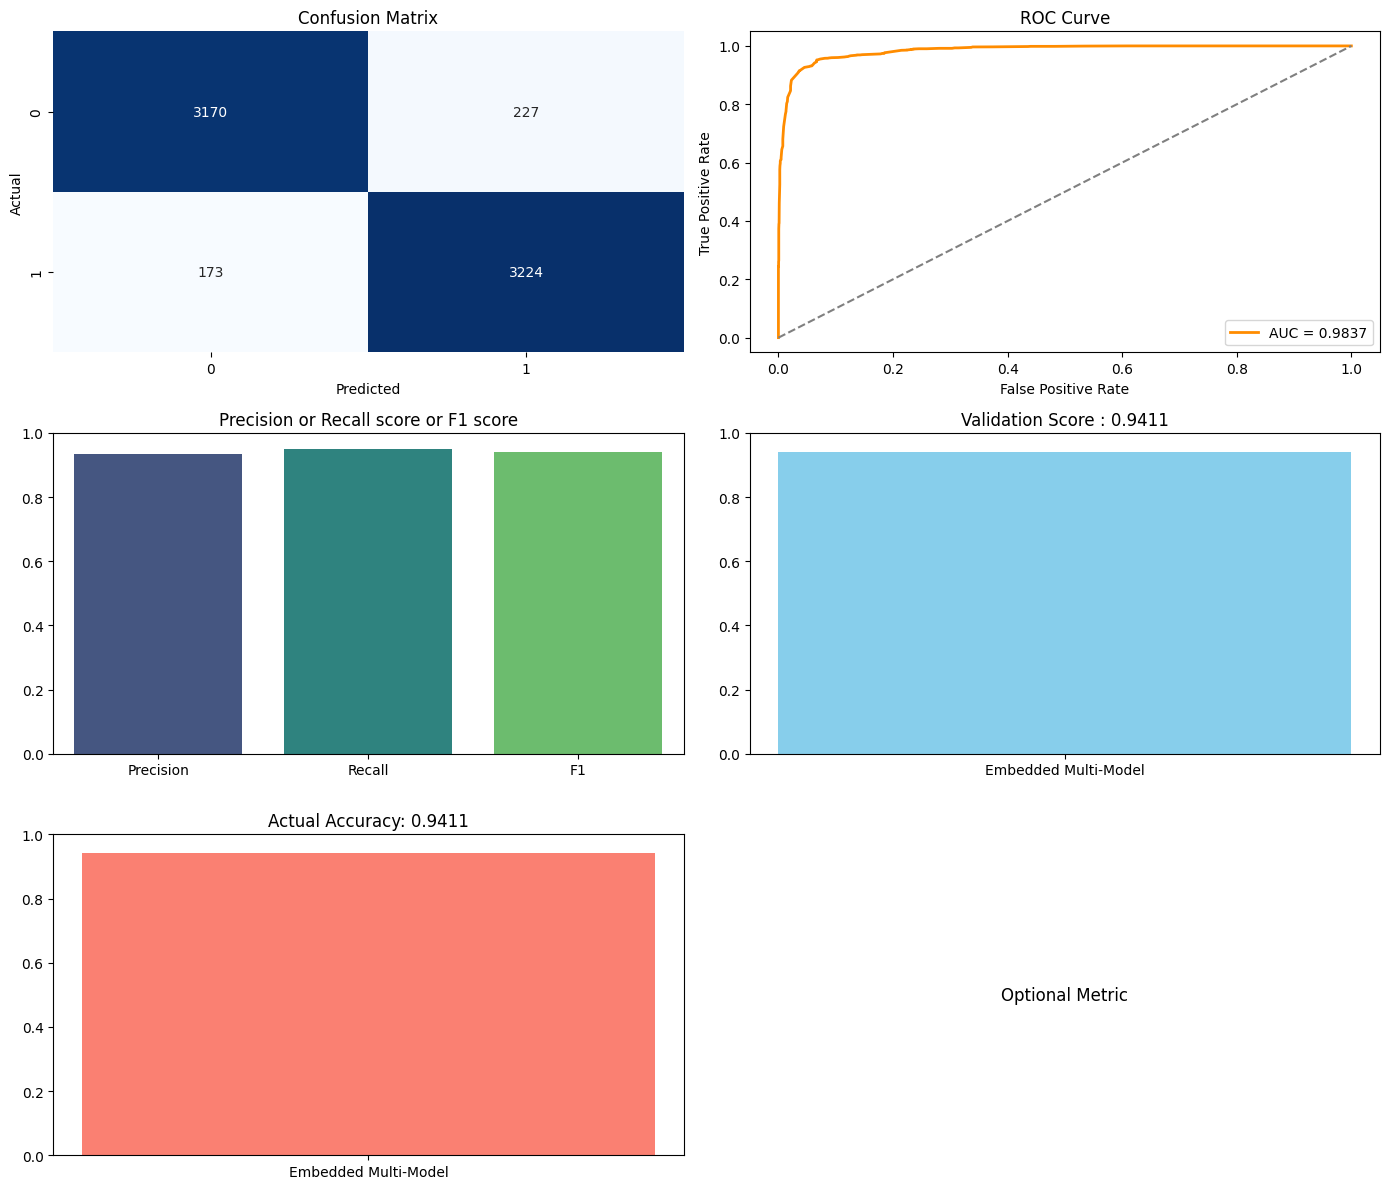

Embedded Multi-Model Algorithm Summary
Validation Score (model.score): 0.9411
Actual Accuracy: 0.9411
Precision: 0.9342
Recall: 0.9491
F1 Score: 0.9416
ROC AUC: 0.9837


In [ ]:
plot_model_evaluation(stack_model, X_val, y_val, model_name="Embedded Multi-Model")

### 7. Final evaluation on the test set

In [ ]:
y_test_pred_ST = stack_model.predict(X_test)

print(f"Confusion matrix:\n {confusion_matrix(y_test, y_test_pred_ST)}")
print(f"Recall: {recall_score(y_test, y_test_pred_ST)}")
print(f"Precision:  {precision_score(y_test, y_test_pred_ST)}")
print(f"F1 Score: {f1_score(y_test, y_test_pred_ST)}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred_ST))

Confusion matrix:
 [[3138  260]
 [ 161 3236]]
Recall: 0.9526052399175743
Precision:  0.9256292906178489
F1 Score: 0.9389235456259973
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      3398
           1       0.93      0.95      0.94      3397

    accuracy                           0.94      6795
   macro avg       0.94      0.94      0.94      6795
weighted avg       0.94      0.94      0.94      6795



### 7.1 Threshold Tuning Using ROC Curve

AUC Score: 0.9811


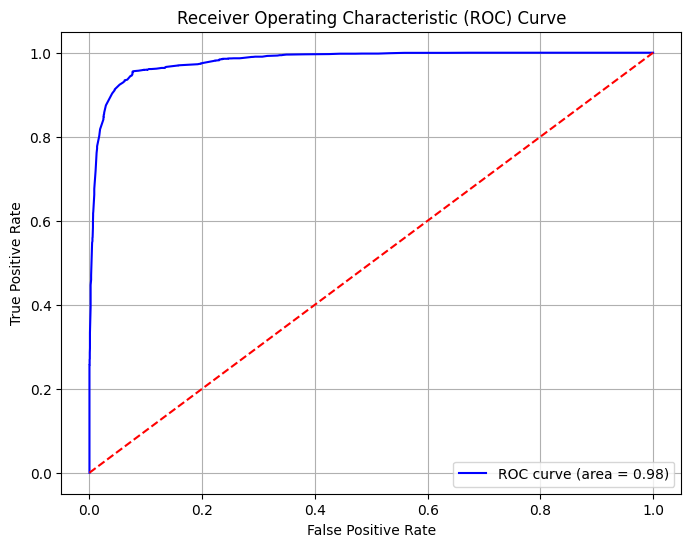

In [ ]:
import matplotlib.pyplot as plt

y_test_proba = stack_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

### 7.2 Optimal Threshold

> Find Best threshold for `Multi-Model`.

In [ ]:
J_scores = tpr - fpr
best_threshold = thresholds[np.argmax(J_scores)]
print(f"Best threshold: {best_threshold:.4f}")

Best threshold: 0.4983


In [ ]:
y_test_pred_new_threshold = (y_test_proba >= best_threshold).astype(int)

print(f"Confusion matrix at new threshold {best_threshold}:\n {confusion_matrix(y_test, y_test_pred_new_threshold)}")
print(f"Recall: {recall_score(y_test, y_test_pred_new_threshold)}")
print(f"Precision: {precision_score(y_test, y_test_pred_new_threshold)}")
print(f"F1 Score: {f1_score(y_test, y_test_pred_new_threshold)}")
print(classification_report(y_test, y_test_pred_new_threshold))

Confusion matrix at new threshold 0.4983166087692315:
 [[3138  260]
 [ 152 3245]]
Recall: 0.9552546364439211
Precision: 0.9258202567760342
F1 Score: 0.9403071573456968
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      3398
           1       0.93      0.96      0.94      3397

    accuracy                           0.94      6795
   macro avg       0.94      0.94      0.94      6795
weighted avg       0.94      0.94      0.94      6795



### 8. Save The `Multi-model`

- Has `98 %` Accuracy on Test data.
- Optimize threshold is `0.49` for the model.

In [ ]:
os.makedirs('model', exist_ok=True)

joblib.dump({'model': stack_model, 'threshold': best_threshold}, 'model/model.pkl')

print("Model saved successfully!")

Model saved successfully!
